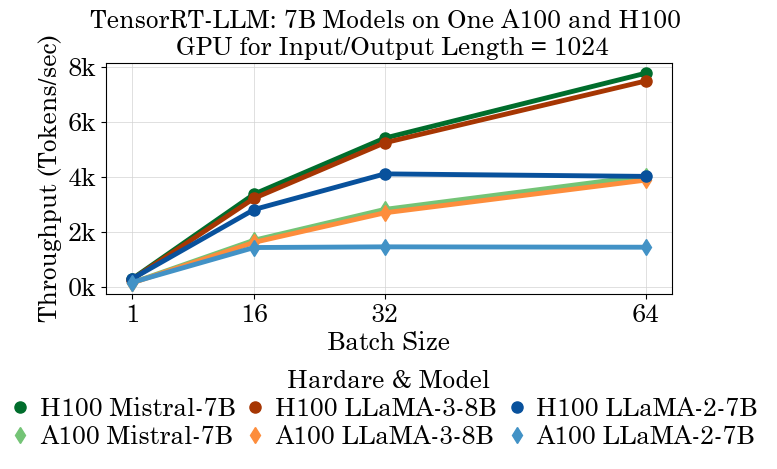

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import FuncFormatter
import csv

alias_legend = {
    "meta-llama/Llama-2-7b-hf": "LLaMA-2-7B",
    "meta-llama/Llama-2-70b-hf": "LLaMA-2-70B",
    "meta-llama/Meta-Llama-3-8B": "LLaMA-3-8B",
    "meta-llama/Meta-Llama-3-70B": "LLaMA-3-70B",
    "mistralai/Mistral-7B-v0.1": "Mistral-7B",
    "mistralai/Mistral-7B-v0.3": "Mistral-7B",
    "mistralai/Mixtral-8x7B-v0.1": "Mixtral-8x7B",
    "Qwen/Qwen2-7B": "Qwen2-7B",
    "Qwen/Qwen2-72B": "Qwen2-72B",
    "BAAI/Aquila-7B": "Aquila-7B",
    "Qwen/Qwen1.5-7B": "Qwen1.5-7B",
    "facebook/opt-13b": "OPT-13B",
    "facebook/opt-6.7b": "OPT-6.7B",
    "huggyllama/llama-13b": "LLaMA-13B",
    "huggyllama/llama-7b": "LLaMA-7B",
    "EleutherAI/gpt-j-6b": "GPT-J-6B",
    "meta-llama/Llama-2-13b-hf": "LLaMA-2-13B",
    "google/gemma-1.1-7b-it": "Gemma-1.1-7B",
    "bigscience/bloom-7b1": "Bloom-7.1B",
    "Deci/DeciLM-7B": "DeciLM-7B",
    "google/gemma-7b": "Gemma-7B",
    "Tensor Parallelism": "TP",
    "Pipeline Parallelism": "PP",
    "Expert Parallelism": "EP",
    "Tensor (2) and Expert (2) Parallelism": "TP & PP",
    "Deepspeed": "DS",
    "TensorRT-LLM": "TRT-LLM",
    "Without": "w/o",
    "With": "w",
    "Nvidia A100 GPU": "A100",
    "Nvidia H100 GPU": "H100",
    "Nvidia GH200 GPU": "GH200",
    "Intel PVC GPU": "PVC",
    "AMD MI250 GPU": "MI250",
    "Habana Gaudi2": "Gaudi2",
    "SambaNova SN40L": "SN40L",
    "Weight = fp16, KV Cache = fp16": "{fp16, fp16}",
    "Weight = fp16, KV Cache = fp8": "{fp16, fp8}",
    "Weight = fp8, KV Cache = fp8": "{fp8, fp8}",
    "Speculative Decoding": "SD",
    "Weight = full_prec, KV Cache = int8": "{fp16, int8}",
    "Weight = full_prec, KV Cache = fp8": "{fp16, fp8}",
    "Weight = int8_sq, KV Cache = int8": "{int8, int8}",
    "Weight = int8_sq, KV Cache = fp8": "{int8, fp8}"
}



def read_csv_without_header(csv_file):
    with open(csv_file, "r", newline="") as f:
        reader = csv.reader(f)
        next(reader)

        rows = []
        for row in reader:
            rows.append(row)
    return rows


def get_matching_row(hardware, numhardware, framework, network, inp_out, batch):
    csv_file = "../All_results.csv"
    rows = read_csv_without_header(csv_file)
    
    for row in rows:
        if row != []:
            Hardware = str(row[0]) 
            Num_of_Hardware = int(row[1])
            Framework = str(row[2])
            Model = str(row[3])
            Input_Output_Length = int(row[4]) 
            Batch_Size = int(row[5])
            Latency = float(row[6])
            Throughput = float(row[7])
            
            if Hardware == hardware:
                if Num_of_Hardware == numhardware:
                    if Framework == framework:
                        if Model == network:
                            if Input_Output_Length == inp_out:
                                if Batch_Size == batch:
                                    return Throughput
    return None
    

def get_data_rows():
    
    results_data = []
    legends = []
    for inp_out in [1024]:
        for network in ["mistralai/Mistral-7B-v0.1","meta-llama/Meta-Llama-3-8B","meta-llama/Llama-2-7b-hf"]:
            for hardware in ["Nvidia H100 GPU", "Nvidia A100 GPU"]:
                batch_row = []
                for batch in [1, 16, 32, 64]:
                    for numhardware in [1]:
                        for framework in ["TensorRT-LLM"]:
                            throughput = get_matching_row(hardware, numhardware, framework, network, inp_out, batch)
                            batch_row.append(throughput)
                if all([x is None for x in batch_row])^ True:
                    results_data.append(batch_row)
                    legends.append(alias_legend[hardware] + " " + alias_legend[network])            
                            
    x_axis_labels = [1, 16, 32, 64]

    colors = ['#006d2c', '#74c476', '#a63603', '#fd8d3c', '#08519c', '#4292c6', "#54278f", "#9e9ac8"]
    symbols = ['o', 'd']*4
    
    return results_data, x_axis_labels, legends, colors, symbols



def plot_multiple_lines(lines_data, x_axis_labels, legends, colors, symbols, title, xlabel, 
                        ylabel, linewidth, markersize, fontsize, n_cols_legend,
                        fig_plot_length, fig_plot_height, legend_title, save_pdf, labelspacing, columnspacing):
    
    plt.figure(figsize=(fig_plot_length, fig_plot_height))
    plt.rcParams['font.family'] = 'Century Schoolbook'
    
    for i, line_data in enumerate(lines_data):
        
        valid_y_axis = [x for x in line_data if x is not None]
        valid_x_axis = x_axis_labels[0:len(valid_y_axis)]
        
        plt.plot(valid_x_axis, valid_y_axis, color=colors[i], marker=symbols[i], 
                 label=str(legends[i]), linewidth = linewidth, markersize = markersize)
    
    plt.grid(color='lightgrey', linestyle='-', linewidth=0.5)
    
    plt.title(title, fontsize = fontsize)
    
    plt.xlabel(xlabel, fontsize = fontsize)
    plt.ylabel(ylabel, fontsize = fontsize)
    
    plt.xticks(x_axis_labels, fontsize = fontsize)
    plt.yticks(fontsize = fontsize)
    
    def thousands_formatter(x, pos):
        return f'{int(x/1000)}k'
    
    plt.gca().yaxis.set_major_formatter(FuncFormatter(thousands_formatter))
    
    plt.legend(title=legend_title, loc='lower center', bbox_to_anchor=(0.5, -0.77), 
               ncol=n_cols_legend, fontsize = fontsize, title_fontsize = fontsize, frameon = False, 
               handlelength = 0, labelspacing = labelspacing, columnspacing = columnspacing)
    
    plt.savefig(save_pdf, dpi=300, bbox_inches='tight', pad_inches=0.03)
    plt.show()
    

lines_data, x_axis_labels, legends, colors, symbols = get_data_rows()

plot_title = "TensorRT-LLM: 7B Models on One A100 and H100 \n GPU for Input/Output Length = 1024"
x_axis_title = "Batch Size"
y_axis_title = "Throughput (Tokens/sec)"

linewidth = 3.5
markersize = 8
fontsize = 18

n_cols_legend = len(legends) // 2 

fig_plot_length = 7.3
fig_plot_height = 3

labelspacing = 0.2
columnspacing = 0.8

legend_title = "Hardare & Model"

save_pdf = "7B_A100_H100.pdf"

plot_multiple_lines(lines_data, x_axis_labels, legends, colors, symbols, 
                    plot_title, x_axis_title, y_axis_title, 
                    linewidth, markersize, fontsize, n_cols_legend, 
                    fig_plot_length, fig_plot_height, legend_title, save_pdf, labelspacing, columnspacing)

In [37]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import FuncFormatter
import csv

alias_legend = {
    "meta-llama/Llama-2-7b-hf": "LLaMA-2-7B",
    "meta-llama/Llama-2-70b-hf": "LLaMA-2-70B",
    "meta-llama/Meta-Llama-3-8B": "LLaMA-3-8B",
    "meta-llama/Meta-Llama-3-70B": "LLaMA-3-70B",
    "mistralai/Mistral-7B-v0.1": "Mistral-7B",
    "mistralai/Mistral-7B-v0.3": "Mistral-7B",
    "mistralai/Mixtral-8x7B-v0.1": "Mixtral-8x7B",
    "Qwen/Qwen2-7B": "Qwen2-7B",
    "Qwen/Qwen2-72B": "Qwen2-72B",
    "BAAI/Aquila-7B": "Aquila-7B",
    "Qwen/Qwen1.5-7B": "Qwen1.5-7B",
    "facebook/opt-13b": "OPT-13B",
    "facebook/opt-6.7b": "OPT-6.7B",
    "huggyllama/llama-13b": "LLaMA-13B",
    "huggyllama/llama-7b": "LLaMA-7B",
    "EleutherAI/gpt-j-6b": "GPT-J-6B",
    "meta-llama/Llama-2-13b-hf": "LLaMA-2-13B",
    "google/gemma-1.1-7b-it": "Gemma-1.1-7B",
    "bigscience/bloom-7b1": "Bloom-7.1B",
    "Deci/DeciLM-7B": "DeciLM-7B",
    "google/gemma-7b": "Gemma-7B",
    "Tensor Parallelism": "TP",
    "Pipeline Parallelism": "PP",
    "Expert Parallelism": "EP",
    "Tensor (2) and Expert (2) Parallelism": "TP & PP",
    "Deepspeed": "DS",
    "TensorRT-LLM": "TRT-LLM",
    "Without": "w/o",
    "With": "w",
    "Nvidia A100 GPU": "A100",
    "Nvidia H100 GPU": "H100",
    "Nvidia GH200 GPU": "GH200",
    "Intel PVC GPU": "PVC",
    "AMD MI250 GPU": "MI250",
    "AMD MI300X GPU": "MI300X",
    "Habana Gaudi2": "Gaudi2",
    "SambaNova SN40L": "SN40L",
    "Weight = fp16, KV Cache = fp16": "{fp16, fp16}",
    "Weight = fp16, KV Cache = fp8": "{fp16, fp8}",
    "Speculative Decoding": "SD",
    "Weight = full_prec, KV Cache = int8": "{fp16, int8}",
    "Weight = full_prec, KV Cache = fp8": "{fp16, fp8}",
    "Weight = int8_sq, KV Cache = int8": "{int8, int8}",
    "Weight = int8_sq, KV Cache = fp8": "{int8, fp8}"
}



def read_csv_without_header(csv_file):
    with open(csv_file, "r", newline="") as f:
        reader = csv.reader(f)
        next(reader)

        rows = []
        for row in reader:
            rows.append(row)
    return rows


def get_matching_row(hardware, numhardware, framework, network, inp_out, batch):
    csv_file = "../All_results.csv"
    rows = read_csv_without_header(csv_file)
    
    for row in rows:
        if row != []:
            Hardware = str(row[0]) 
            Num_of_Hardware = int(row[1])
            Framework = str(row[2])
            Model = str(row[3])
            Input_Output_Length = int(row[4]) 
            Batch_Size = int(row[5])
            Latency = float(row[6])
            Throughput = float(row[7])
            
            if Hardware == hardware:
                if Num_of_Hardware == numhardware:
                    if Framework == framework:
                        if Model == network:
                            if Input_Output_Length == inp_out:
                                if Batch_Size == batch:
                                    return Latency, Throughput
    return None,None

# AMD MI300X GPU,1,vLLM,meta-llama/Llama-2-7b-hf,1024,1,16,2.2758256473345684,
# AMD MI250 GPU,1,vLLM,meta-llama/Llama-2-7b-hf,1024,1,16,2.1599140379267436
# Nvidia H100 GPU,1,vLLM,meta-llama/Llama-2-7b-hf,1024,1,16,0.4216477160962919
# Nvidia GH200 GPU,1,vLLM,meta-llama/Llama-2-7b-hf,1024,1,16,0.3566369306606551
# Nvidia A100 GPU,1,Deepspeed-MII,meta-llama/Llama-2-7b-hf,1024,1,16,1.6275303363800049
# SambaNova SN40L,8,sambaflow,mistralai/Mistral-7B-v0.1,1024,1,16,0.5
# Nvidia H100 GPU,1,TensorRT-LLM,mistralai/Mistral-7B-v0.1,1024,1,16,0.4019413948059082

    
    
def get_data_rows():
    results_data = []
    legends = []
    for inp_out in [2048]:
        for hardware in ["Nvidia A100 GPU"]:
            for framework in ["vLLM", "Deepspeed-MII"]:
                batch_row = []
                for network in ["mistralai/Mixtral-8x7B-v0.1"]:
                    for batch in [64]:
                        for numhardware in [4]:
                            latency,throughput = get_matching_row(hardware, numhardware, framework, network, inp_out, batch)
                            print(hardware, numhardware, framework, network, inp_out, batch,latency,throughput)
    
get_data_rows()
    

Nvidia A100 GPU 4 vLLM mistralai/Mixtral-8x7B-v0.1 2048 64 79.80424677859992 3284.8377195672724
Nvidia A100 GPU 4 Deepspeed-MII mistralai/Mixtral-8x7B-v0.1 2048 64 76.16347527503967 3441.8597504033532


In [38]:

3441.8597504033532/3284.8377195672724

1.0478020664158612